Imports & Loading (Data Prep)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    sentiment = pd.read_csv('../data/sentiment.csv')
    traders = pd.read_csv('../data/trader_data.csv')
    print("Data Loaded Successfully")
except FileNotFoundError:
    print("Error: Check your file paths in 'data/' folder")

# --- FIX 1: Use lowercase 'date' (matches your CSV) ---
sentiment['date'] = pd.to_datetime(sentiment['date'])

# --- FIX 2: Use 'Timestamp IST' (matches your CSV) ---
# We use errors='coerce' to handle any weird formats safely
traders['timestamp'] = pd.to_datetime(traders['Timestamp IST'], errors='coerce')

# Create a date-only column for merging
traders['date_only'] = traders['timestamp'].dt.normalize()

# --- FIX 3: Update merge keys to use 'date' (lowercase) ---
df = traders.merge(sentiment, left_on='date_only', right_on='date', how='left')
df = df.drop_duplicates()

print(f"Merged Dataset Shape: {df.shape}")
df.head()

Data Loaded Successfully
Merged Dataset Shape: (211224, 22)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,timestamp_x,date_only,timestamp_y,value,classification,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12


Feature Engineering (The Metrics)

In [4]:
# 1. Fix PnL Column Name (Capital 'C', space, 'PnL')
df['is_win'] = df['Closed PnL'] > 0

# 2. Handle Missing 'Leverage' Column
# Since your data doesn't have 'leverage', we use 'Size USD' as a proxy for risk
df['size_bucket'] = np.where(df['Size USD'] > 10000, 'High Vol (>10k)', 'Low Vol (<=10k)')

# 3. Create Daily Stats
# Note: We use 'classification' (lowercase) and 'Account' (uppercase) to match your files
daily_stats = df.groupby(['date_only', 'classification']).agg({
    'Closed PnL': 'sum',     # Total Profit
    'is_win': 'mean',        # Win Rate
    'Size USD': 'mean',      # Avg Trade Size (instead of leverage)
    'Account': 'nunique'     # Active Traders
}).reset_index()

# Rename for clarity
daily_stats.rename(columns={'is_win': 'win_rate'}, inplace=True)

print("Daily stats created successfully!")
daily_stats.head()

Daily stats created successfully!


,date_only,classification,Closed PnL,win_rate,Size USD,Account
0,2023-01-05,Fear,0.000000,0.000000,159.000000,1
1,2023-05-12,Neutral,0.000000,0.000000,5556.203333,1
2,2023-12-14,Greed,-205.434737,0.363636,10291.213636,1
3,2023-12-15,Greed,-24.632034,0.000000,5304.975000,1
4,2023-12-16,Greed,0.000000,0.000000,5116.256667,1


Visualizations (Part B - Insights)

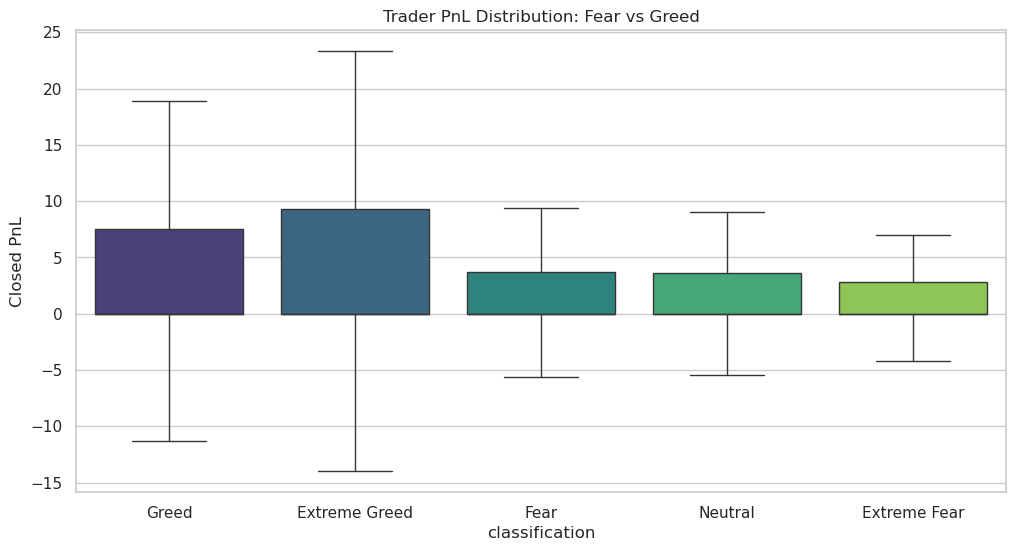

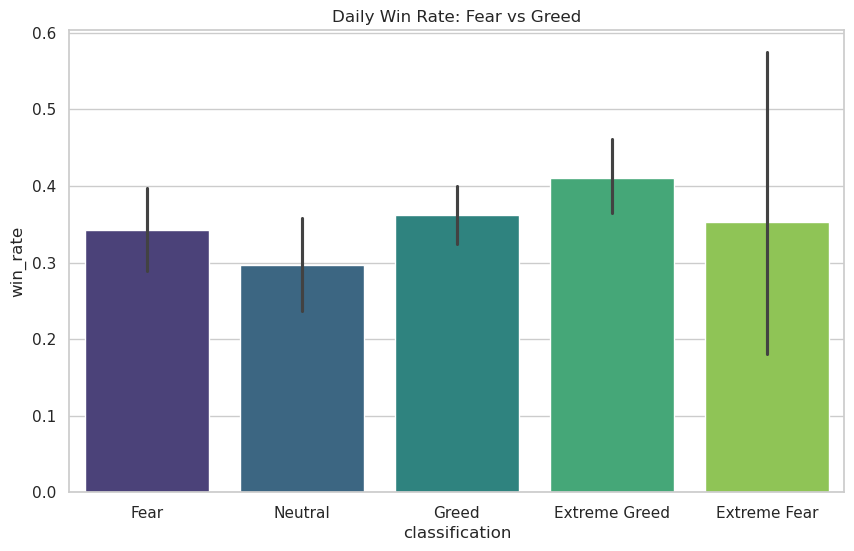

In [6]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='classification', y='Closed PnL', data=df, showfliers=False, hue='classification', palette="viridis", legend=False)
plt.title('Trader PnL Distribution: Fear vs Greed')
plt.savefig('../data/pnl_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='win_rate', data=daily_stats, hue='classification', palette='viridis', legend=False)
plt.title('Daily Win Rate: Fear vs Greed')
plt.show()